# Alignment of spatial transcriptomics data

In this tutorial, we show how to use moscot `moscot.problems.space.AlignmentProblem` for aligning spatial transcriptomics data.

When multiple spatial transcriptomics datasets are generated, it is desirable to integrate them and align them in the same coordinate system.
Moscot re-implements a method firstly introduced in **PASTE** <cite data-cite="zeira:22">Zeira et al. (2022)</cite> to align 
spatial transcriptomics data, integrating both gene expression and spatial similarity.

For the purpose of this tutorial, we will show the application of the `AlignmentProblem` in simulated data.

For this tutorial, you will also need the package `squidpy` for spatial data plotting. You can either install it with `pip install squidpy` or simply install `moscot` with `squidpy` as an optional dependency `pip install moscot[spatial]`.

First, let's import some libraries.

In [22]:
import squidpy as sq
import moscot as mt
import scanpy as sc

sc.logging.print_header()
print(f"moscot=={mt.__version__}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.1 pynndescent==0.5.7
moscot==0.1


We will load the public data available in moscot.

In [23]:
from moscot.datasets import sim_align

adata = sim_align()

Let's take a look at the data by plotting couple of summary statistics. We can realize by plotting the data that it consists of
3 different slides (batches).

 The data consists of 3 slides with the same number of data points: 
 0    400
1    400
2    400
Name: batch, dtype: int64


/Users/giovanni.palla/Projects/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


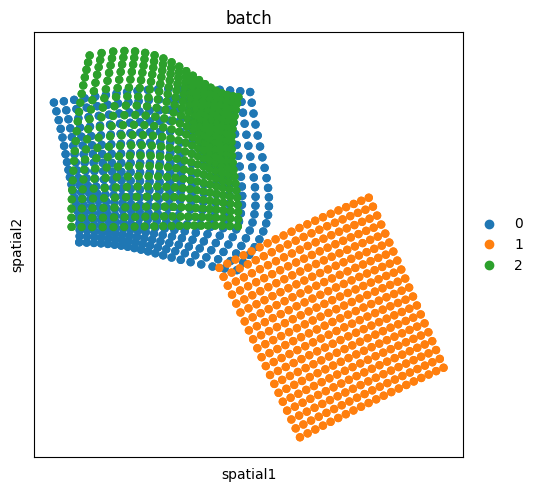

In [24]:
print(
    " The data consists of 3 slides with the same number of data points: \n",
    adata.obs.batch.value_counts(),
)
sq.pl.spatial_scatter(adata, shape=None, library_id="batch", color="batch")

## Aligning spatial transcriptomics data with moscot `AlignmentProblem`
With moscot, it is possible to learn a cross-dataset mapping by leveraging Fused-Gromov-Wasserstein (FGW) Optimal Transport. A basic description of the algorithm is the following:

Given a set of observations that share some features in the metric space, and some other features in different metric spaces, the FGW method aims at finding the optimal matching between these two set of observations, based on both shared and unique features.

In our case, the "shared" metric space could be the one defined by a set of genes that is measured across spatial transcriptomics data. 
On the other hand, the "unique" metric spaces are the spatial coordinates, which are unique for each single slide.

The moscot `AlignmentProblem` interfaces the FGW algorithm to the user in a friendly API that is the following.
First, let's initialize the problem and take a look at the arguments. To be initialized, the `AlignmentProblem` only requires the `AnnData` object and the `batch_key` corresponding to the slide (or library) id.

In [25]:
from moscot.problems.space import AlignmentProblem

ap = AlignmentProblem(adata=adata)

After initialization, we need to "prepare" the problem. In this particular case, we need to pay attention to 1 arguments: `policy`.
The available policies are:
- `star`: if we wish to align all slides to a reference slide
- `sequential` (default): if we wish to align each slide to the subsequent one, in case we have a sequence of slides.

The choice of the policy varies with the use cases, for the sake of this tutorial we will showcase the `sequential` policy.

In [26]:
ap = ap.prepare(batch_key="batch").solve()

INFO     Computing pca with `n_comps=30` using `adata.X`                                                           
INFO     Computing pca with `n_comps=30` using `adata.X`                                                           
INFO     Solving problem OTProblem[stage='prepared', shape=(400, 400)].                                            
INFO     Solving problem OTProblem[stage='prepared', shape=(400, 400)].                                            


In the previous cell, we both prepared and solved the problems, using defaults arguments. However, it's important to take into consideration the the `alpha` value, which balances the weight of each loss ("unique" v. "shared" spaces). With alpha close to 0, the "shared" space loss is weighted more, with alpha close to 1, the "unique" space loss is balanced more. We suggest to try various values that might be more fitting to the specific use case.

## Analysis of the resulting transport map

Solving the OT problem means that we computed the optimal transport plan between the various slides. We can now use it to align our datasets. There are two methods to perform the alignment:
- `warping` (defaults): which warps the spatial coordinates of the source slide to the target slide.
- `affine` : which computes the affine transformation from the transport map and simply shift and rotate the coordinates preserving the original space.

Let's for instance warp the slides to a reference slide of choice. To do that, we need to pass as `reference` the key corresponding to the slide of choice.
When using the `align` method of the `AlignmentProblem`, by default it modifies the input `AnnData` in place by saving the transformed coordinates in a new `adata.obsm` key.

/Users/giovanni.palla/Projects/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


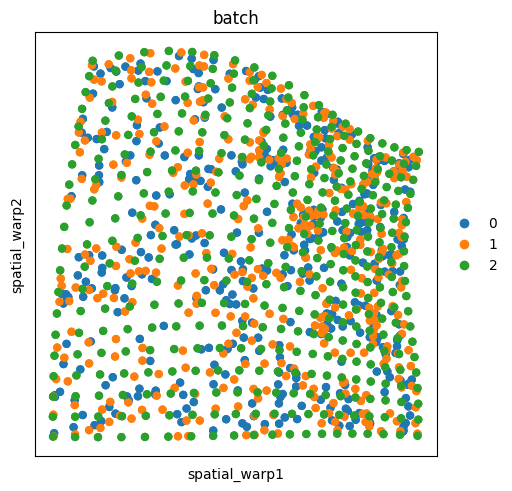

In [27]:
ap.align(reference="2")
sq.pl.spatial_scatter(
    adata, shape=None, spatial_key="spatial_warp", library_id="batch", color="batch"
)

We can appreciate that the slides "0" and "1" have been warped to match the coordinate system of the slide "2". Nevertheless, the results do not seem particularly good, since the points are scattered around. 
One explanation for this is that the gene expression variability is driving the computed transportation plan, and it might not be representative of the spatial structure of the data (a simple grid in this case). It should be noted that the 3 simulated slides have been generated with random gene expression data.

Let's try to solve the problems again but this time with a higher alpha value.

INFO     Solving problem OTProblem[stage='solved', shape=(400, 400)].                                              
INFO     Solving problem OTProblem[stage='solved', shape=(400, 400)].                                              


/Users/giovanni.palla/Projects/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


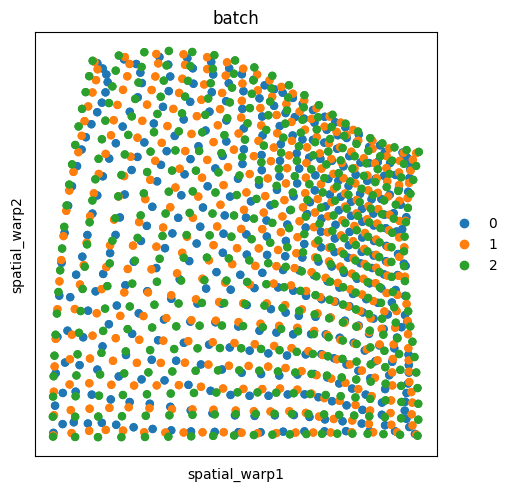

In [28]:
ap = ap.solve(alpha=0.9)
ap.align(reference="2")
sq.pl.spatial_scatter(
    adata, shape=None, spatial_key="spatial_warp", library_id="batch", color="batch"
)

Now the arrangement of the points look a lot more coherent.

Let's now try the `affine` alignment method. Let's also change the reference slide.

/Users/giovanni.palla/Projects/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


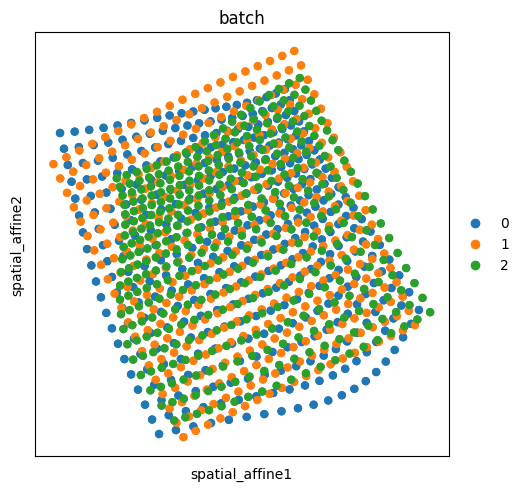

In [29]:
ap.align(reference="1", mode="affine")
sq.pl.spatial_scatter(
    adata, shape=None, spatial_key="spatial_affine", library_id="batch", color="batch"
)

We can appreciate how the slides have now been projected on the same reference coordinates of slide "1" yet without warping the original space. We can also plot the original space to appreciate the result.

/Users/giovanni.palla/Projects/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


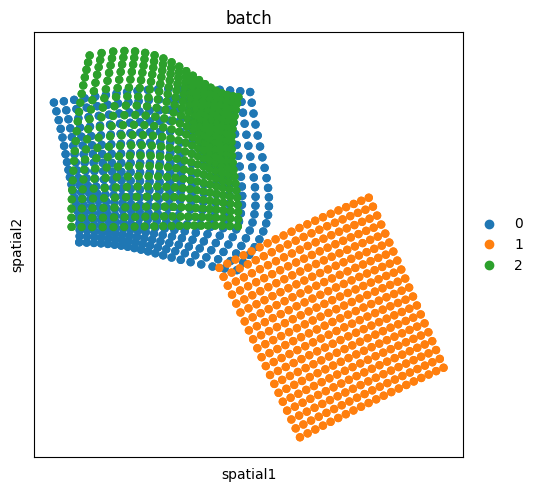

In [30]:
sq.pl.spatial_scatter(adata, shape=None, library_id="batch", color="batch")